# Heatmaps: IR vs GR

In [1]:
import gc
import os
import warnings
from os import path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings('ignore')

In [4]:
sample_size = 56        # 24, 56
plots_dir = os.path.join('out', 'plots', 'heatmap', f'n{sample_size}')
calculations_dir = os.path.join('out', 'calculations', f'n{sample_size}')

os.makedirs(plots_dir, exist_ok=True)
os.makedirs(calculations_dir, exist_ok=True)

metrics = {
    # 'sb.bin': 'Stereotypical bias',     # TODO add to shared calculations
    'acc_equality_diff.bin': 'Accuracy equality difference',
    'acc_equality_ratio.bin': 'Accuracy equality ratio',
    'disp_impact.bin': 'Disparate impact',
    'equal_opp_diff.bin': 'Equal opportunity difference',
    'equal_opp_ratio.bin': 'Equal opportunity ratio',
    'pred_equality_diff.bin': 'Predictive equality difference',
    'pred_equality_ratio.bin': 'Predictive equality ratio',
    'stat_parity.bin': 'Statistical parity',
    'neg_pred_parity_diff.bin': 'Negative predictive parity difference',
    'neg_pred_parity_ratio.bin': 'Negative predictive parity ratio',
    'pos_pred_parity_diff.bin': 'Positive predictive parity difference',
    'pos_pred_parity_ratio.bin': 'Positive predictive parity ratio',
}

In [5]:
with open(path.join(calculations_dir, 'gr.bin'), 'rb') as f:
    gr = pd.DataFrame(np.fromfile(f).astype(np.float16), columns=['gr'])

with open(path.join(calculations_dir, 'ir.bin'), 'rb') as f:
    ir = pd.DataFrame(np.fromfile(f).astype(np.float16), columns=['ir'])

## v1

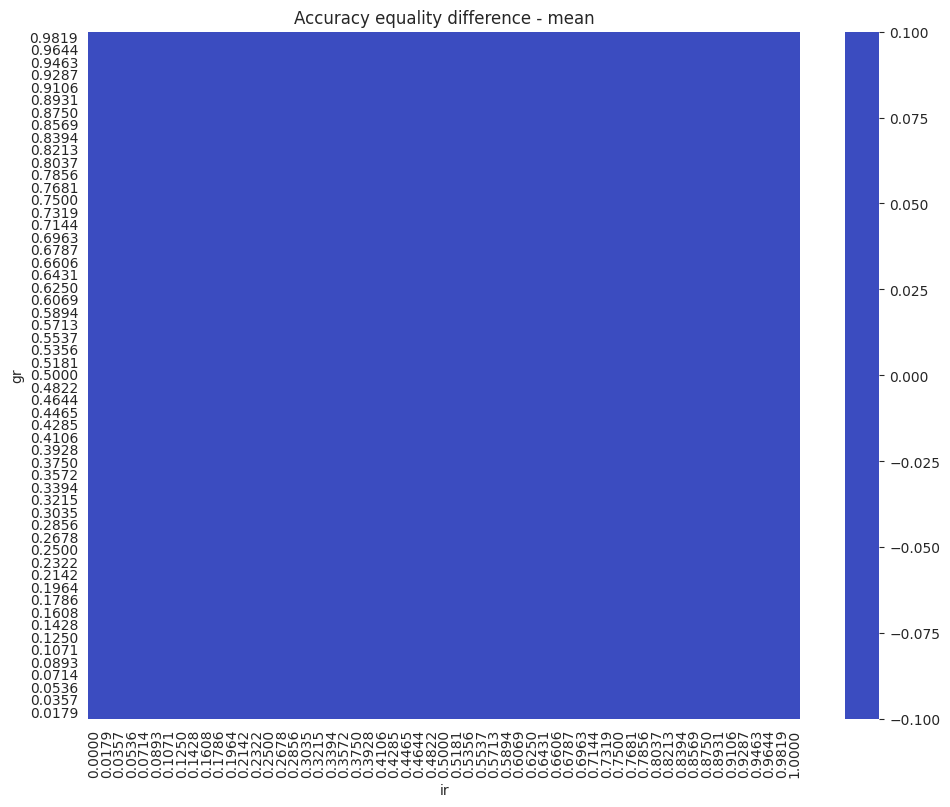

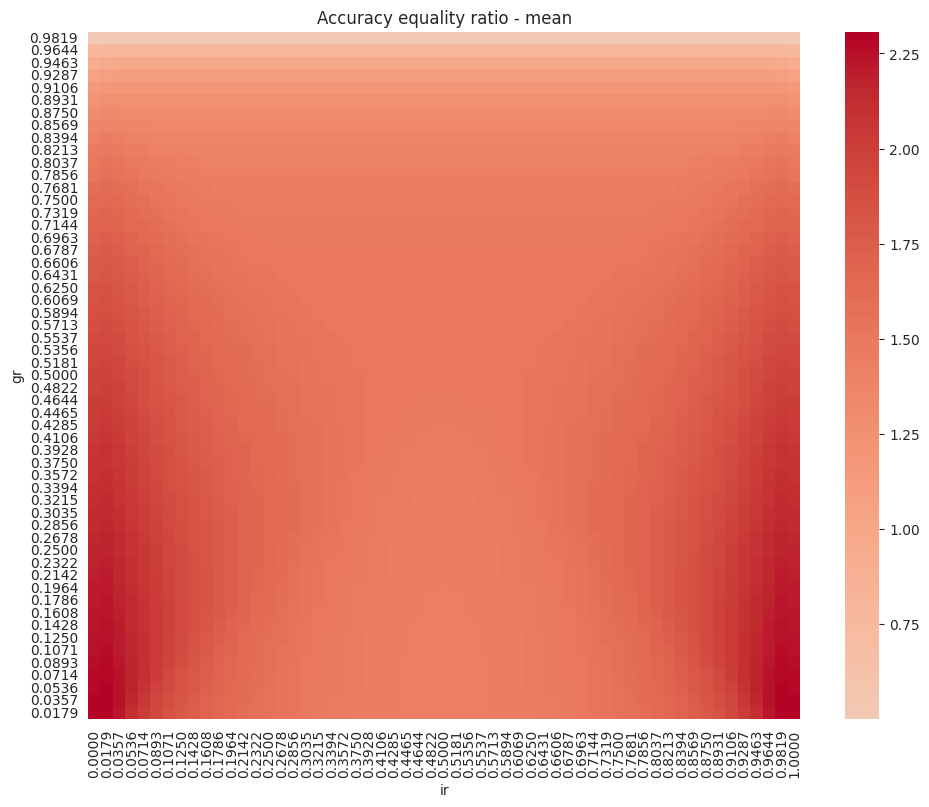

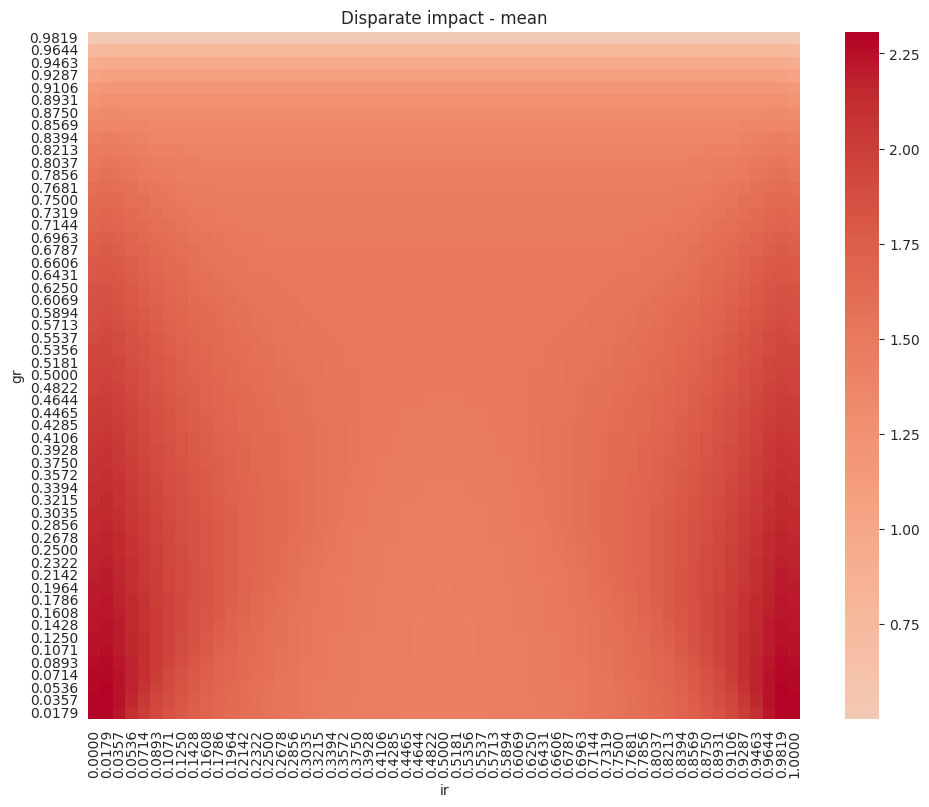

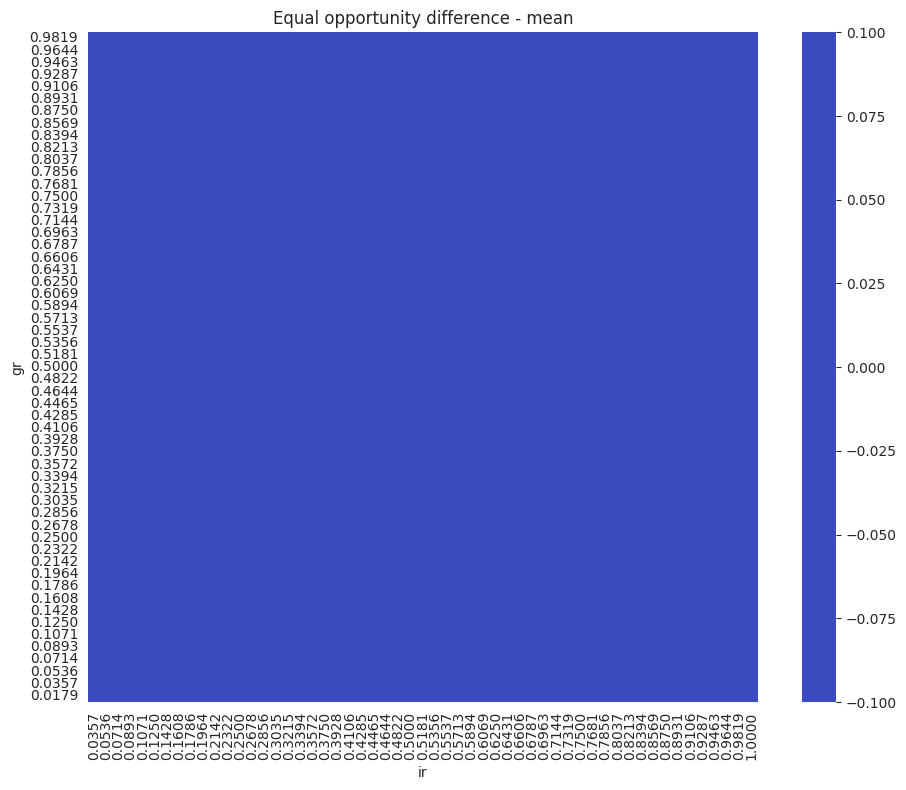

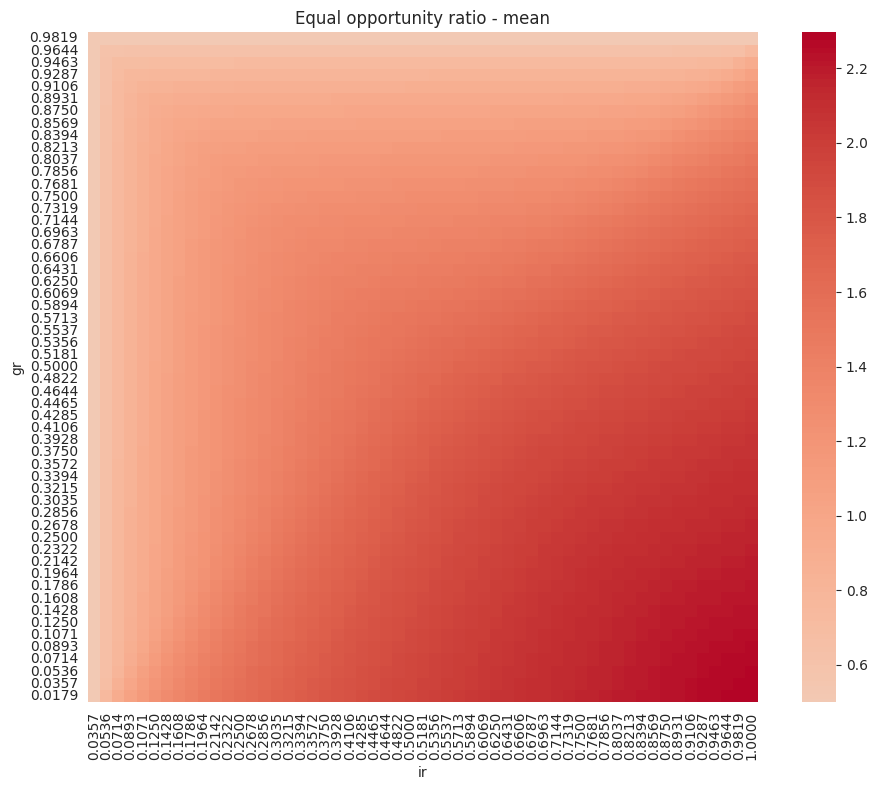

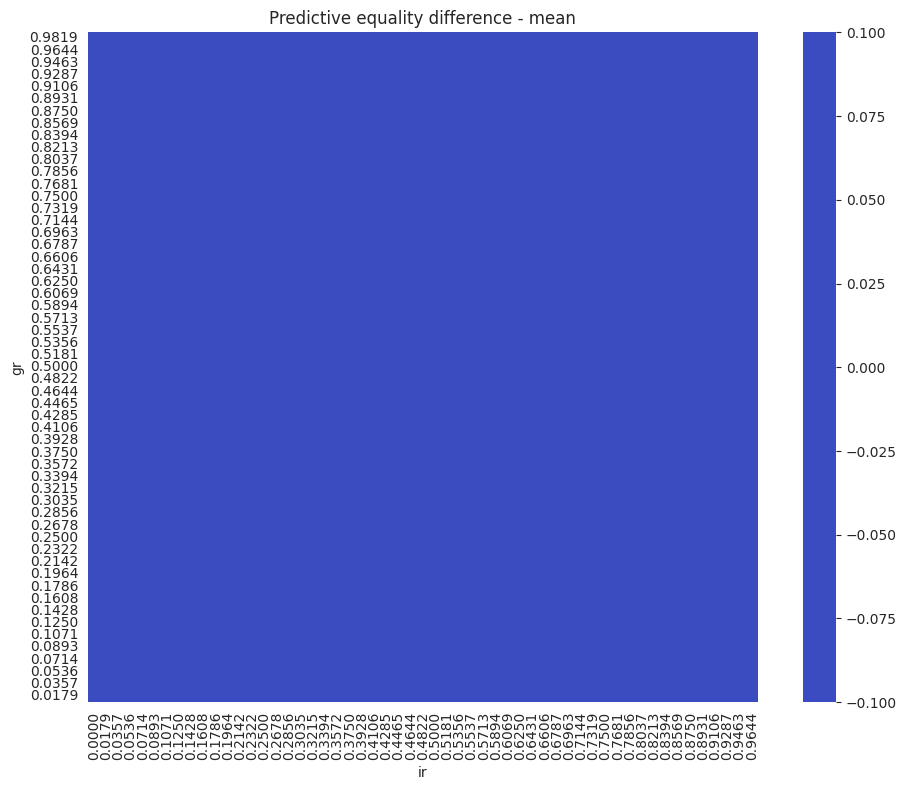

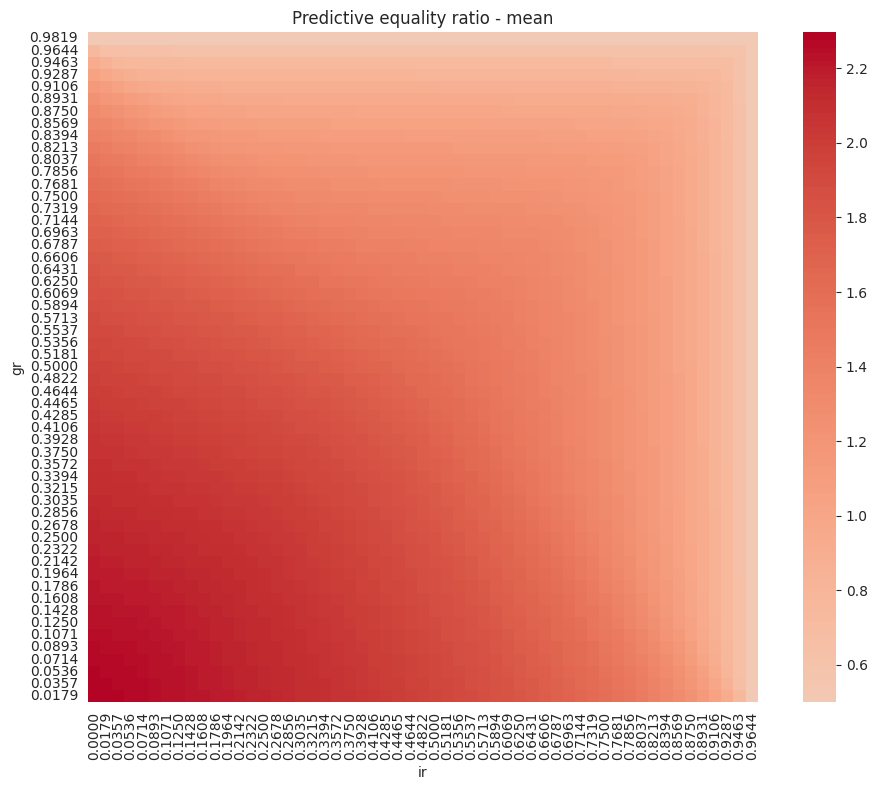

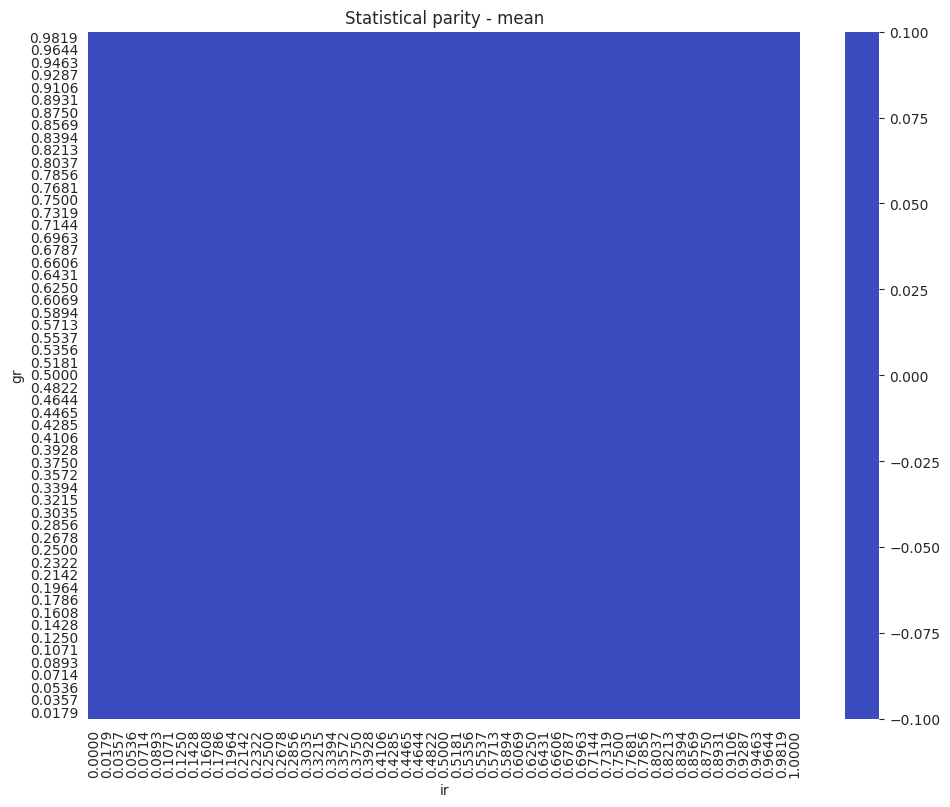

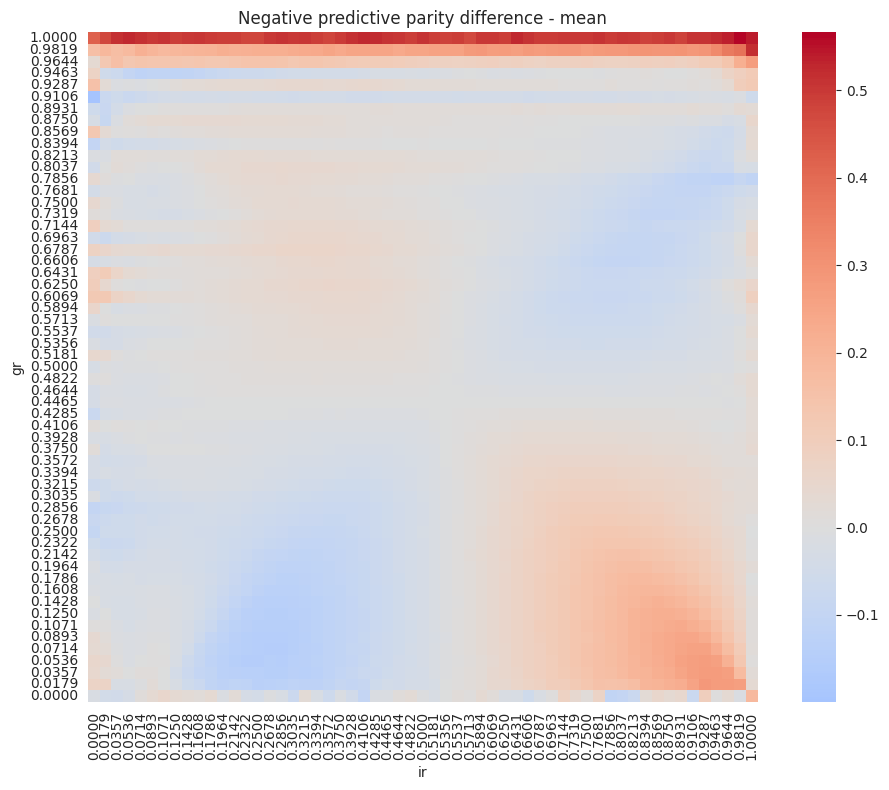

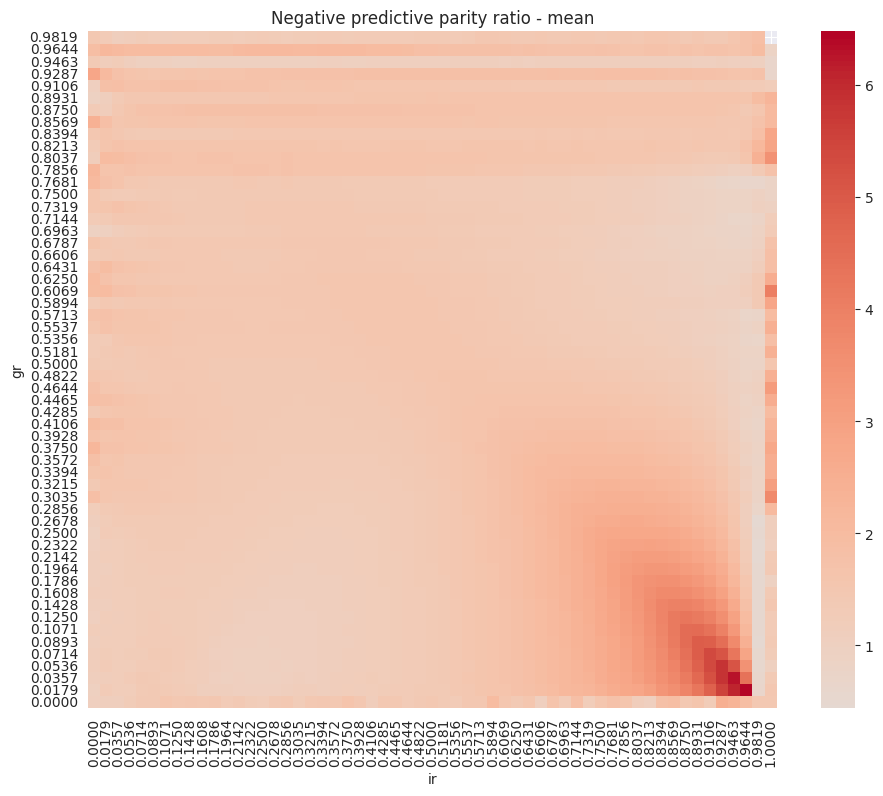

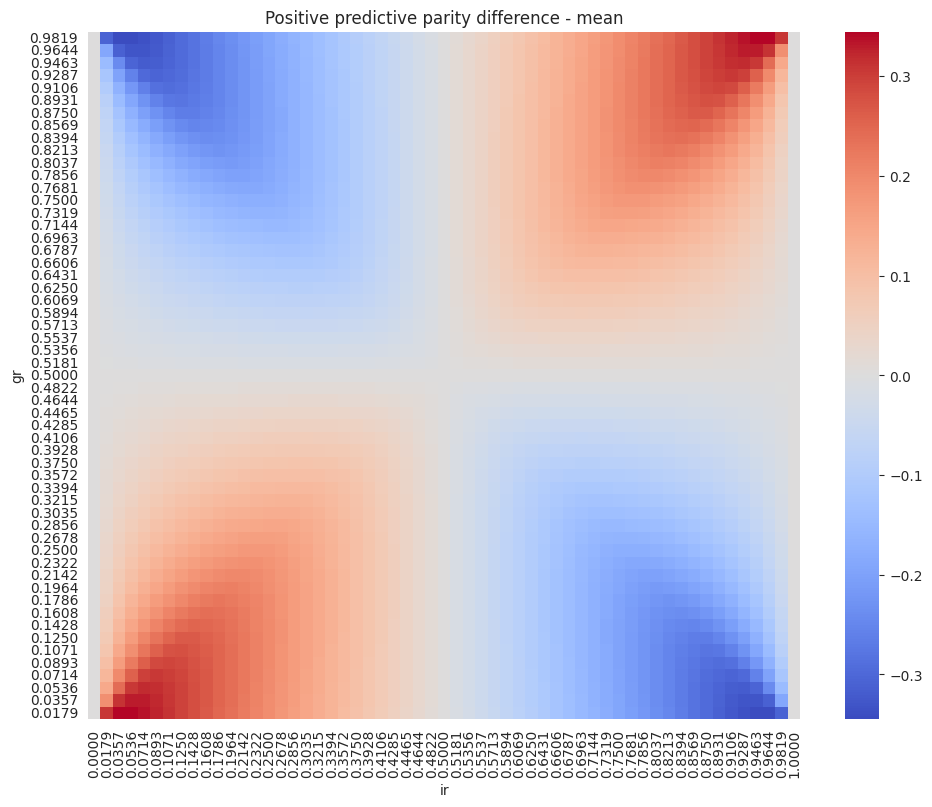

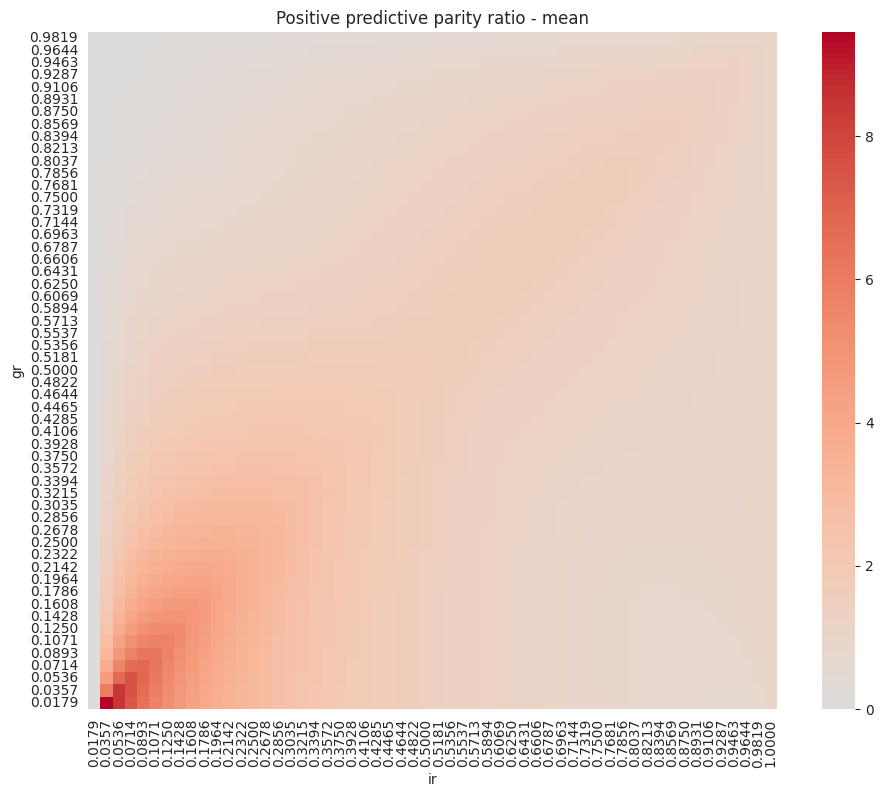

In [4]:
for metric_f, metric_n in metrics.items():
    with open(path.join(calculations_dir, metric_f), 'rb') as f:
        metric = pd.DataFrame(np.fromfile(f).astype(np.float16), columns=[metric_n])

    df = pd.concat([gr, ir, metric], axis=1).replace(np.inf, np.nan).dropna(axis=0, how='any')

    df = df.melt(id_vars=['gr', 'ir'], var_name='metric', value_name='value').drop('metric', axis=1)
    df = df.pivot_table(index='gr', columns='ir', values='value')

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        df,
        cmap='coolwarm',
        center=0,
        square=True,
        xticklabels=[f'{x:.4f}' for x in df.columns],
        yticklabels=[f'{y:.4f}' for y in df.index],
    )
    plt.title(f'{metric_n} - mean')

    # invert y
    ax = plt.gca()
    ax.invert_yaxis()

    plt.tight_layout()
    plt.savefig(path.join(plots_dir, f'{metric_n}_hm_v1.png'))
    plt.show()

    # garbage collection
    del df
    del metric
    plt.close()
    gc.collect()

# NaNs visualisation - scatterplot

In [11]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    ax_histx.set_title('GR')
    ax_histy.set_title('IR')

    # the scatter plot:
    ax.scatter(x, y, alpha=.1, s=1)
    # TODO jitter with seaborn

    ax.set_xlabel('GR')
    ax.set_ylabel('IR')

    # now determine nice limits by hand:
    binwidth = 0.1
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(0, lim, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')

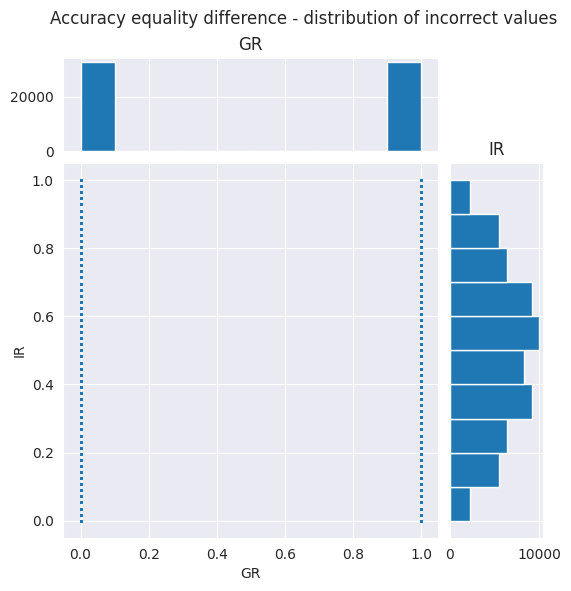

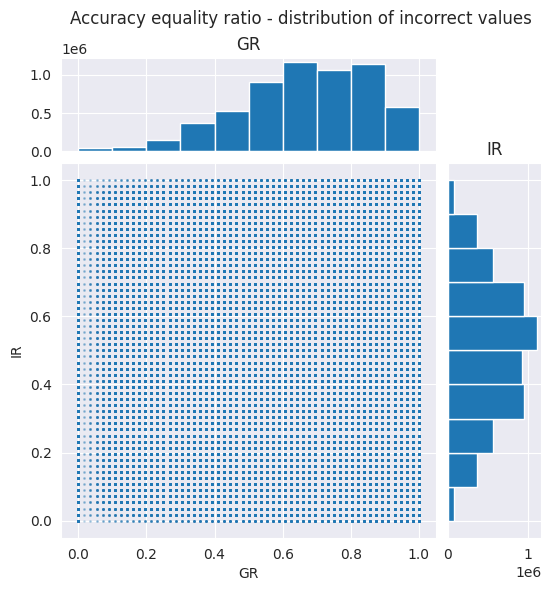

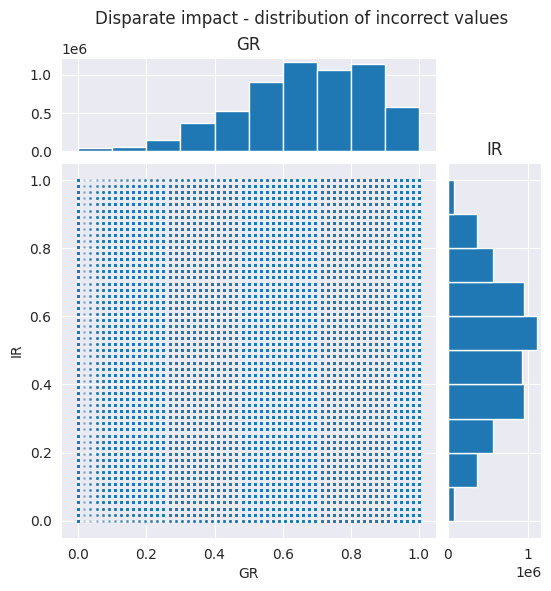

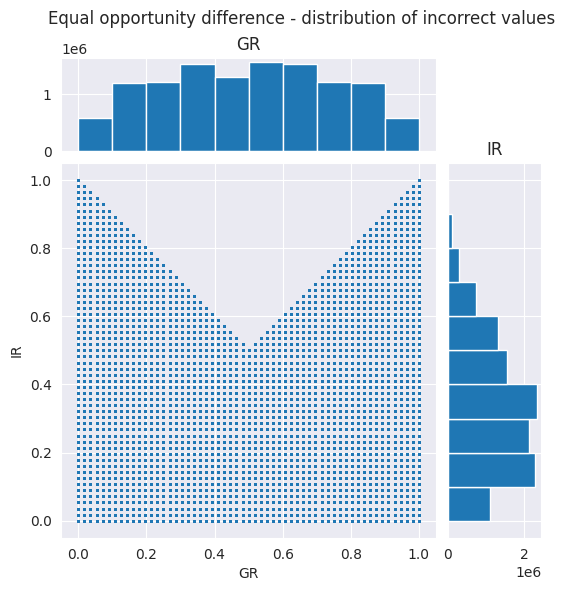

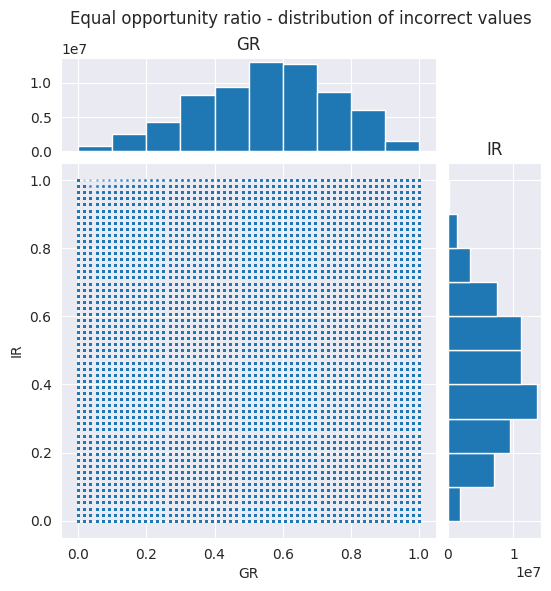

In [ ]:
for metric_f, metric_n in metrics.items():
    with open(path.join(calculations_dir, metric_f), 'rb') as f:
        metric = pd.DataFrame(np.fromfile(f).astype(np.float16), columns=[metric_n])

    df = pd.concat([gr, ir, metric], axis=1).replace(np.inf, np.nan)
    # leave NaNs
    df = df.loc[df[metric_n].isna()]

    fig = plt.figure(figsize=(6, 6))
    fig.suptitle(f'{metric_n} - distribution of incorrect values')
    gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.05, hspace=0.05)

    ax = fig.add_subplot(gs[1, 0])
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
    scatter_hist(df['gr'], df['ir'], ax, ax_histx, ax_histy)

    plt.savefig(path.join(plots_dir, f'scatter_jitter_{metric_n}.png'))
    plt.show()

    # garbage collection
    del df
    del metric
    plt.close()